Thermal (IR) images

In [3]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers, models, applications, regularizers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.patches as patches
from PIL import Image
import os
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, roc_auc_score, f1_score
import gc
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import zipfile
zip_file = "/content/drive/MyDrive/archive.zip"
extract_dir = "final_data"
if not os.path.exists(extract_dir) or not os.listdir(extract_dir):
  os.makedirs(extract_dir, exist_ok=True)
  with zipfile.ZipFile(zip_file, 'r') as ref:
    ref.extractall(extract_dir)
  print('Extraction complete')
else:
    print("Extraction skipped/already exists.")

Extraction skipped/already exists.


In [39]:
#suppose we work with Thermal
classes = {'bike': 0, 'bus': 1, 'car': 2, 'person': 3, 'sign': 4, 'motor': 5, 'light': 6, 'truck': 7}

train_dataset =tf.keras.preprocessing.image_dataset_from_directory(
    '/content/final_data/Train_RGB/train_rgb_patches', #path to your data
    labels='inferred',
    label_mode='int',
    class_names=list(classes.keys()),
    image_size=(64, 64),
    batch_size=512,
    shuffle=True,
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/final_data/Val_RGB/val_rgb_patches',
    labels='inferred',
    label_mode='int',
    class_names=list(classes.keys()),
    image_size=(64, 64),
    batch_size=512,
    shuffle=False,
)

Found 108297 files belonging to 8 classes.
Found 10956 files belonging to 8 classes.


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

# CNN model

In [6]:
# Custom CNN Model
from keras.regularizers import l2, l1_l2
cnn_model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
  layers.Dropout(0.1),

  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.Dropout(0.2),

  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D(2, 2),

  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
  layers.Dropout(0.1),
  layers.Dense(8, activation='softmax')
])
optimizer = Adam(learning_rate = 0.001)
cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 58, 58, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 107648)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    13,779,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,873,352 (52.92 MB)

 Trainable params: 13,873,352 (52.92 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
cnn_history = cnn_model.fit(train_dataset, validation_data=val_dataset, callbacks=callbacks, epochs=30, verbose=1)

Epoch 1/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - accuracy: 0.4459 - loss: 252.2964 - val_accuracy: 0.5302 - val_loss: 1.9322 - learning_rate: 0.0010
Epoch 2/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.6654 - loss: 1.5127 - val_accuracy: 0.6332 - val_loss: 1.5529 - learning_rate: 0.0010
Epoch 3/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.7237 - loss: 1.2817 - val_accuracy: 0.6825 - val_loss: 1.3970 - learning_rate: 0.0010
Epoch 4/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.7579 - loss: 1.1529 - val_accuracy: 0.7417 - val_loss: 1.2136 - learning_rate: 0.0010
Epoch 5/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.7781 - loss: 1.0698 - val_accuracy: 0.7604 - val_loss: 1.1586 - learning_rate: 0.0010
Epoch 6/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.8050 - loss: 0.9905 - val_accuracy: 0.8069 - val_loss: 1.0603 - learning_rate: 0.0010
Epoch 7/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8342 - loss

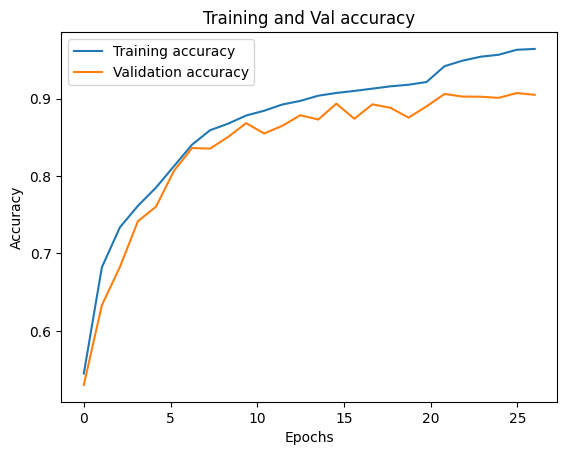

In [9]:
# training vs validation acc
plt.plot(np.linspace(0, len(cnn_history.history['accuracy']), len(cnn_history.history['accuracy'])), cnn_history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(cnn_history.history['val_accuracy']), len(cnn_history.history['val_accuracy'])), cnn_history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

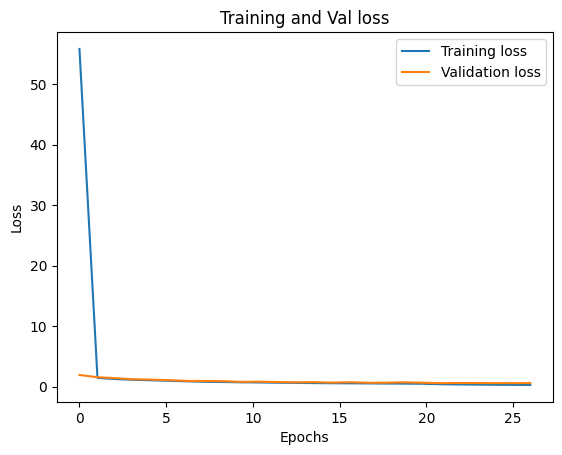

In [10]:
# training vs validation loss
plt.plot(np.linspace(0, len(cnn_history.history['loss']), len(cnn_history.history['loss'])), cnn_history.history['loss'], label='Training loss')
plt.plot(np.linspace(0, len(cnn_history.history['val_loss']), len(cnn_history.history['val_loss'])), cnn_history.history['val_loss'], label = 'Validation loss')
plt.title('Training and Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [11]:
cnn_preds = cnn_model.predict(val_dataset)
cnn_labels = cnn_preds.argmax(axis=1)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [12]:
true_labels = []
class_names = val_dataset.class_names

for images, labels in val_dataset:
    true_labels.extend(labels.numpy())

In [13]:
import builtins
misclassified_indices_cnn = []

for i, (true_label, predicted_label) in enumerate(builtins.zip(true_labels, cnn_labels)):
    if true_label != predicted_label:
        misclassified_indices_cnn.append(i)

print("len Misclassified indices for cnn:", len(misclassified_indices_cnn))

len Misclassified indices for cnn: 1029


In [14]:
y_true = np.array(true_labels)
y_prob_pred = cnn_preds
y_pred = cnn_labels

In [15]:
np.save("CNNTrueLabelsThermal.npy", y_true)
np.save("CNNPredLabelsThermal.npy", y_pred)

Classification report for cnn validation: 

              precision    recall  f1-score   support

        bike     0.5283    0.6474    0.5818       173
         bus     0.7037    0.3220    0.4419       177
         car     0.9271    0.9727    0.9493      5527
      person     0.9043    0.9334    0.9186      2359
        sign     0.9054    0.8303    0.8662      1626
       motor     0.4510    0.3966    0.4220        58
       light     0.9283    0.8030    0.8611      1000
       truck     0.1818    0.1111    0.1379        36

    accuracy                         0.9061     10956
   macro avg     0.6912    0.6271    0.6474     10956
weighted avg     0.9042    0.9061    0.9029     10956

Accuracy: 0.9061
F1 Score: 0.6474
AUC: 0.9614


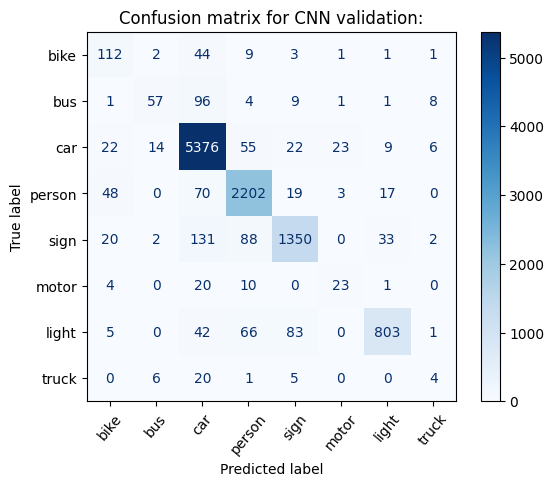

In [16]:
from sklearn.metrics import confusion_matrix
report = classification_report(y_true, y_pred, digits=4, target_names=val_dataset.class_names)
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
auc = roc_auc_score(y_true, y_prob_pred, multi_class='ovr')

print("Classification report for cnn validation: \n")
print(report)
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_dataset.class_names)
disp.plot(xticks_rotation=50, cmap='Blues')
plt.title("Confusion matrix for CNN validation:")
plt.show()

In [17]:
cnn_model.save('/content/drive/MyDrive/Models/cnn_thermal_model.h5')

# VGG model

In [8]:
# Pretrained VGG16 Model

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
for layer in base_model.layers[:-6]:  # Fine-tune last 4 layers
    layer.trainable = False

vgg_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax', kernel_regularizer=regularizers.l2(0.001))
])
optimizer = Adam(learning_rate = 0.0001)
vgg_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [9]:
vgg_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,781,384 (56.39 MB)

 Trainable params: 9,505,928 (36.26 MB)

 Non-trainable params: 5,275,456 (20.12 MB)

In [10]:
vgg_history = vgg_model.fit(train_dataset, validation_data=val_dataset, callbacks=callbacks, epochs=8, verbose=1)

Epoch 1/8
212/212 ━━━━━━━━━━━━━━━━━━━━ 38s 108ms/step - accuracy: 0.6366 - loss: 1.9490 - val_accuracy: 0.9283 - val_loss: 0.4383 - learning_rate: 1.0000e-04
Epoch 2/8
212/212 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9206 - loss: 0.4643 - val_accuracy: 0.9457 - val_loss: 0.3571 - learning_rate: 1.0000e-04
Epoch 3/8
212/212 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9473 - loss: 0.3461 - val_accuracy: 0.9480 - val_loss: 0.3383 - learning_rate: 1.0000e-04
Epoch 4/8
212/212 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9615 - loss: 0.2782 - val_accuracy: 0.9510 - val_loss: 0.3278 - learning_rate: 1.0000e-04
Epoch 5/8
212/212 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9704 - loss: 0.2357 - val_accuracy: 0.9557 - val_loss: 0.2976 - learning_rate: 1.0000e-04
Epoch 6/8
212/212 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9793 - loss: 0.1941 - val_accuracy: 0.9549 - val_loss: 0.2900 - learning_rate: 1.0000e-04
Epoch 7/8
212/212 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy

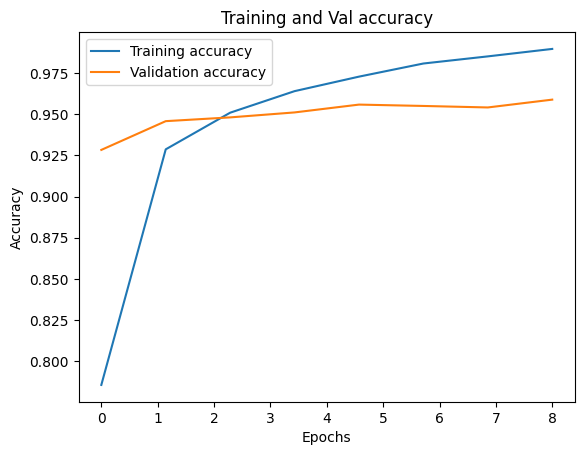

In [11]:
# training vs validation acc
plt.plot(np.linspace(0, len(vgg_history.history['accuracy']), len(vgg_history.history['accuracy'])), vgg_history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(vgg_history.history['val_accuracy']), len(vgg_history.history['val_accuracy'])), vgg_history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

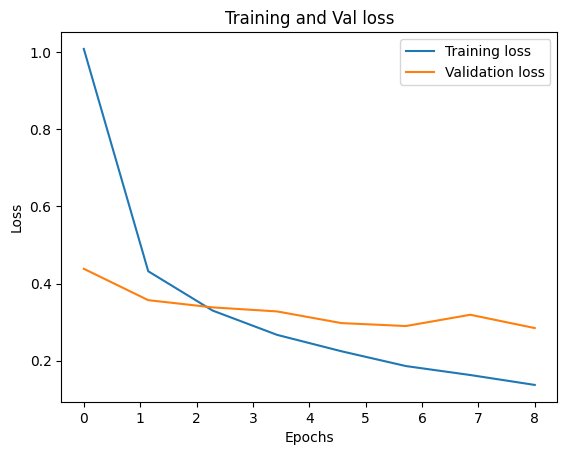

In [12]:
# training vs validation loss
plt.plot(np.linspace(0, len(vgg_history.history['loss']), len(vgg_history.history['loss'])), vgg_history.history['loss'], label='Training loss')
plt.plot(np.linspace(0, len(vgg_history.history['val_loss']), len(vgg_history.history['val_loss'])), vgg_history.history['val_loss'], label = 'Validation loss')
plt.title('Training and Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [13]:
vgg_preds = vgg_model.predict(val_dataset)
vgg_labels = vgg_preds.argmax(axis=1)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step


In [14]:
vgg_true_labels = []

for images, labels in val_dataset:
    vgg_true_labels.extend(labels.numpy())

In [15]:
import builtins
misclassified_indices_vgg = []

for i, (true_label, predicted_label) in enumerate(builtins.zip(vgg_true_labels, vgg_labels)):
    if true_label != predicted_label:
        misclassified_indices_vgg.append(i)

print("len Misclassified indices for vgg:", len(misclassified_indices_vgg))

len Misclassified indices for vgg: 452


In [16]:
vgg_y_true = np.array(vgg_true_labels)
vgg_y_prob_pred = vgg_preds
vgg_y_pred = vgg_labels

In [17]:
np.save("VGGTrueLabelsThermal.npy", vgg_y_true)
np.save("VGGPredLabelsThermal.npy", vgg_y_pred)

Classification report for vgg validation: 

              precision    recall  f1-score   support

        bike     0.8278    0.8613    0.8442       173
         bus     0.7113    0.5706    0.6332       177
         car     0.9812    0.9814    0.9813      5527
      person     0.9612    0.9767    0.9689      2359
        sign     0.9503    0.9410    0.9456      1626
       motor     0.6230    0.6552    0.6387        58
       light     0.9376    0.9460    0.9418      1000
       truck     0.4138    0.3333    0.3692        36

    accuracy                         0.9587     10956
   macro avg     0.8008    0.7832    0.7904     10956
weighted avg     0.9578    0.9587    0.9581     10956

Accuracy: 0.9587
F1 Score: 0.7904
AUC: 0.9874


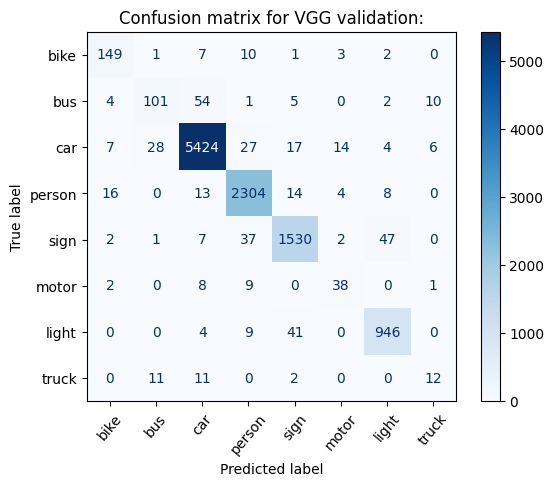

In [18]:
from sklearn.metrics import confusion_matrix
report = classification_report(vgg_y_true, vgg_y_pred, digits=4, target_names=val_dataset.class_names)
acc = accuracy_score(vgg_y_true, vgg_y_pred)
f1 = f1_score(vgg_y_true, vgg_y_pred, average='macro')
auc = roc_auc_score(vgg_y_true, vgg_y_prob_pred, multi_class='ovr')

print("Classification report for vgg validation: \n")
print(report)
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

cm_vgg = confusion_matrix(vgg_y_true, vgg_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_vgg, display_labels=val_dataset.class_names)
disp.plot(xticks_rotation=50, cmap='Blues')
plt.title("Confusion matrix for VGG validation:")
plt.show()

In [43]:
vgg_model.save('/content/drive/MyDrive/Models/vgg_Thermalmodel.h5')

# Autoencoder

In [20]:
input = layers.Input(shape=(64, 64, 3))

l1 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input)
l1 = layers.BatchNormalization()(l1)
l2 = layers.MaxPooling2D(2, padding='same')(l1)
l3 = layers.Dropout(0.3)(l2)
l4 = layers.Conv2D(128, (3, 3),  padding='same', activation='relu')(l3)
l4 = layers.BatchNormalization()(l4)
l5 = layers.MaxPooling2D(2, padding='same')(l4)
l6 = layers.GlobalAveragePooling2D()(l5)
encoded = layers.Dense(128, activation='relu')(l6)
l7 = layers.Dense(16*16*64, activation='relu')(encoded)
l8 = layers.Reshape((16, 16, 64))(l7)
l9 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(l8)
decoder = layers.Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='sigmoid')(l9)

In [21]:
autoencoder = models.Model(input, decoder)
encoder = models.Model(input, encoded)

autoencoder.compile(optimizer='adam', loss='mse')

In [22]:
normalization = layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization(x), y))

In [23]:
autoen_train_dataset = train_dataset.map(lambda x, y: (x, x)) # Map input as both input and target
autoen_val_dataset = val_dataset.map(lambda x, y: (x, x)) # Map input as both input and target

In [24]:
autoencoder.fit(autoen_train_dataset,
                validation_data=autoen_val_dataset,
                epochs=100,
                callbacks=callbacks,
                verbose=1)

Epoch 1/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 38s 105ms/step - loss: 0.0274 - val_loss: 0.0339 - learning_rate: 0.0010
Epoch 2/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0126 - val_loss: 0.0276 - learning_rate: 0.0010
Epoch 3/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0112 - val_loss: 0.0170 - learning_rate: 0.0010
Epoch 4/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0108 - val_loss: 0.0121 - learning_rate: 0.0010
Epoch 5/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0105 - val_loss: 0.0106 - learning_rate: 0.0010
Epoch 6/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0102 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 7/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0101 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 8/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0098 - val_loss: 0.0108 - learning_rate: 0.0010
Epoch 9/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0097 - val_loss: 0.0102 - learning_rat

In [25]:
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16384)          │     2,113,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,676,619 (25.47 MB)

 Trainable params: 2,225,411 (8.49 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 4,450,824 (16.98 MB)

In [26]:
#extract features
def extract_features(dataset, encoder):
    features, labels = [], []
    for x_batch, y_batch in dataset:
        batch_features = encoder.predict(x_batch)
        features.append(batch_features)
        labels.append(y_batch)
    return np.concatenate(features), np.concatenate(labels, axis=0)

x_train, y_train = extract_features(train_dataset, encoder)
x_val, y_val = extract_features(val_dataset, encoder)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1

In [27]:
# dense classifier for autoencoder
ae_model = models.Sequential([
    layers.Input(shape=(x_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(8, activation='softmax')
])
optimizer = Adam(learning_rate=0.0001)
ae_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
history_ae = ae_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, verbose=1, callbacks=callbacks)

Epoch 1/100
3385/3385 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.6298 - loss: 1.1744 - val_accuracy: 0.7888 - val_loss: 0.6752 - learning_rate: 1.0000e-04
Epoch 2/100
3385/3385 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7771 - loss: 0.7185 - val_accuracy: 0.8072 - val_loss: 0.6251 - learning_rate: 1.0000e-04
Epoch 3/100
3385/3385 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7981 - loss: 0.6456 - val_accuracy: 0.8269 - val_loss: 0.5639 - learning_rate: 1.0000e-04
Epoch 4/100
3385/3385 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8042 - loss: 0.6196 - val_accuracy: 0.8335 - val_loss: 0.5435 - learning_rate: 1.0000e-04
Epoch 5/100
3385/3385 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8128 - loss: 0.5917 - val_accuracy: 0.8410 - val_loss: 0.5173 - learning_rate: 1.0000e-04
Epoch 6/100
3385/3385 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8186 - loss: 0.5758 - val_accuracy: 0.8418 - val_loss: 0.5240 - learning_rate: 1.0000e-04
Epoch 7/100
3385/3385 ━━━━━━━━━━━━━━━━━━━━ 7s

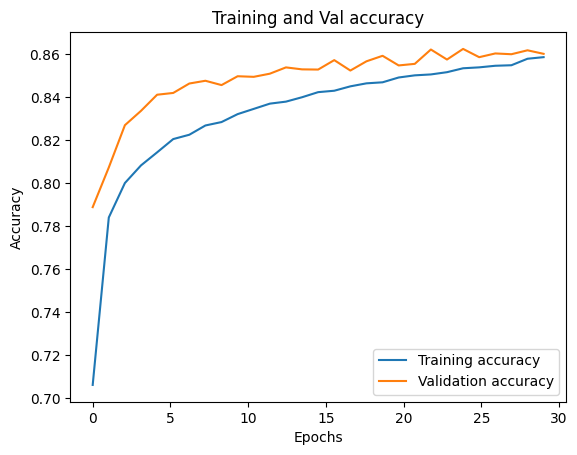

In [30]:
# training vs validation acc
plt.plot(np.linspace(0, len(history_ae.history['accuracy']), len(history_ae.history['accuracy'])), history_ae.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(history_ae.history['val_accuracy']), len(history_ae.history['val_accuracy'])), history_ae.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

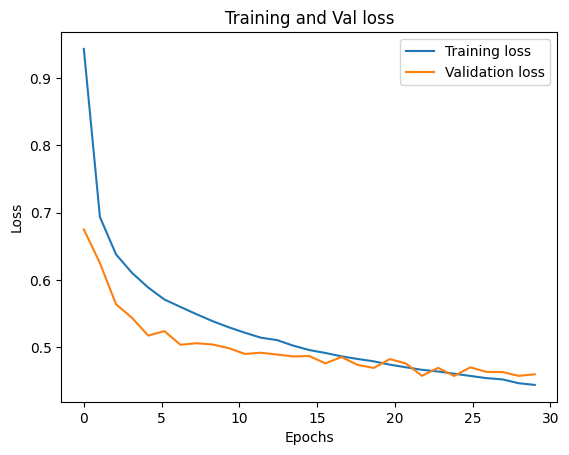

In [31]:
# training vs validation loss
plt.plot(np.linspace(0, len(history_ae.history['loss']), len(history_ae.history['loss'])), history_ae.history['loss'], label='Training loss')
plt.plot(np.linspace(0, len(history_ae.history['val_loss']), len(history_ae.history['val_loss'])), history_ae.history['val_loss'], label = 'Validation loss')
plt.title('Training and Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [32]:
ae_preds = ae_model.predict(x_val)
ae_labels = ae_preds.argmax(axis=1)

343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [33]:
# flatten true labels from validation set
ae_true_labels = y_val.flatten()

In [34]:
import builtins
misclassified_indices_ae = []

misclassified_indices_ae = [i for i, (t, p) in enumerate(zip(ae_true_labels, ae_labels)) if t != p]
print("len Misclassified indices for ae:", len(misclassified_indices_ae))

len Misclassified indices for ae: 1509


In [35]:
np.save("AETrueLabelsThermal.npy", ae_true_labels)
np.save("AEPredLabelsThermal.npy", ae_labels)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification report for ae validation: 

              precision    recall  f1-score   support

        bike     0.4626    0.3931    0.4250       173
         bus     0.3529    0.0339    0.0619       177
         car     0.8795    0.9611    0.9185      5527
      person     0.8156    0.8961    0.8540      2359
        sign     0.8882    0.7571    0.8174      1626
       motor     0.3636    0.0690    0.1159        58
       light     0.9332    0.7120    0.8077      1000
       truck     0.0000    0.0000    0.0000        36

    accuracy                         0.8623     10956
   macro avg     0.5869    0.4778    0.5000     10956
weighted avg     0.8512    0.8623    0.8506     10956

Accuracy: 0.8623
F1 Score: 0.5000
AUC: 0.9218


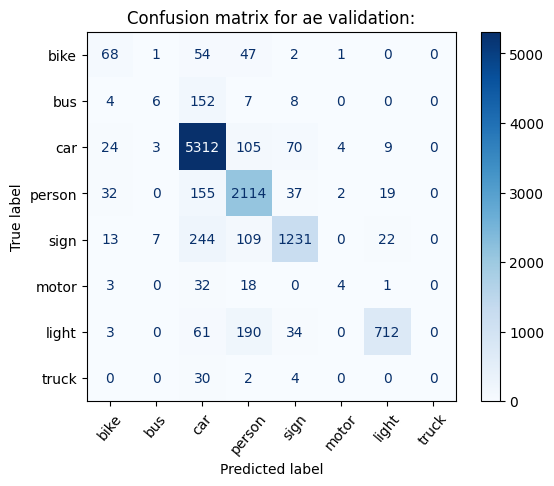

In [41]:
from sklearn.metrics import confusion_matrix
ae_report = classification_report(ae_true_labels, ae_labels, digits=4, target_names=val_dataset.class_names)
ae_acc = accuracy_score(ae_true_labels, ae_labels)
ae_f1 = f1_score(ae_true_labels, ae_labels, average='macro')
ae_auc = roc_auc_score(ae_true_labels, ae_preds, multi_class='ovr')

print("Classification report for ae validation: \n")
print(ae_report)
print(f"Accuracy: {ae_acc:.4f}")
print(f"F1 Score: {ae_f1:.4f}")
print(f"AUC: {ae_auc:.4f}")

cm_ae = confusion_matrix(ae_true_labels, ae_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ae, display_labels=val_dataset.class_names)
disp.plot(xticks_rotation=50, cmap='Blues')
plt.title("Confusion matrix for ae validation:")
plt.show()

In [42]:
autoencoder.save('/content/drive/MyDrive/Models/autoencoder_Thermalmodel.h5')
ae_model.save('/content/drive/MyDrive/Models/ae_classifier_Thermalmodel.h5')